In [23]:
import numpy as np

from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from time import time


class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_s_s = feature_subsample_size
        self.trees_param = trees_parameters
        self.models = []
        self.features = []
        self.rmse_train = []
        self.times = []
        self.rmse_val = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        rmse_val_bool = False
        if (X_val is not None) and (y_val is not None):
            rmse_val_bool = True
            y_pred_val = 0

        y_pred_train = 0
        cur_time = 0

        if self.feature_s_s is None:
            self.feature_s_s = X.shape[1] // 3

        for i in range(self.n_estimators):
            start = time()
            obj_idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            feat_idx = np.random.choice(X.shape[1], self.feature_s_s, replace=False)
            self.features.append(feat_idx)
            x_train = X[obj_idx, :][:, feat_idx]
            y_train = y[obj_idx]
            regressor = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_param)
            regressor.fit(x_train, y_train)
            self.models.append(regressor)
            if rmse_val_bool:
                y_pred_val += regressor.predict(X_val[:, feat_idx])
                self.rmse_val.append(np.sqrt(((y_pred_val / (i + 1) - y_val) ** 2).sum() / X_val.shape[0]))

            y_pred_train += regressor.predict(X[:, feat_idx])
            self.rmse_train.append(np.sqrt(((y_pred_train / (i + 1) - y) ** 2).sum() / x_train.shape[0]))

            cur_time += time() - start
            self.times.append(cur_time)

        if rmse_val_bool:
            return self.rmse_train, self.rmse_val, self.times
        else:
            return self.rmse_train, self.times

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        y_pred = 0
        i = 0
        for model in self.models:
            y_pred += model.predict(X[:, self.features[i]])
            i += 1
        return y_pred / self.n_estimators


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_s_s = feature_subsample_size
        self.trees_param = trees_parameters
        self.models = []
        self.features = []
        self.alphas = []
        self.rmse_train = []
        self.times = []
        self.rmse_val = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        if self.feature_s_s is None:
            self.feature_s_s = X.shape[1] // 3

        f = 0
        f_val = 0

        rmse_val_bool = False
        if (X_val is not None) and (y_val is not None):
            rmse_val_bool = True

        cur_time = 0

        def loss(alpha, y, f, y_pred):
            return ((f + alpha * y_pred - y) ** 2).sum()

        for i in range(self.n_estimators):
            start = time()
            feat_idx = np.random.choice(X.shape[1], self.feature_s_s, replace=False)
            self.features.append(feat_idx)
            regressor = DecisionTreeRegressor(max_depth=self.max_depth, **self.trees_param)
            self.models.append(regressor)
            x_train = X[:, feat_idx]
            regressor.fit(x_train, y - f)
            y_pred = regressor.predict(x_train)
            alpha = minimize_scalar(loss, args=(y, f, y_pred)).x
            self.alphas.append(alpha)
            if rmse_val_bool:
                y_pred_val = regressor.predict(X_val[:, feat_idx])
                f_val += alpha * self.learning_rate * y_pred_val
                self.rmse_val.append(np.sqrt(((f_val - y_val) ** 2).sum() / X_val.shape[0]))

            f += alpha * self.learning_rate * y_pred
            self.rmse_train.append(np.sqrt(((f - y) ** 2).sum() / x_train.shape[0]))

            cur_time += time() - start
            self.times.append(cur_time)

        if rmse_val_bool:
            return self.rmse_train, self.rmse_val, self.times
        else:
            return self.rmse_train, self.times

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        res = 0
        i = 0
        for model in self.models:
            y_pred = model.predict(X[:, self.features[i]])
            res += y_pred * self.alphas[i] * self.learning_rate
            i += 1
        return res

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import pandas as pd
data = pd.read_csv("kc_house_data.csv")

In [3]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
y = data["price"]
y

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64

#Подготовка данных

In [5]:
data = data.drop("price", axis = 1)

In [6]:
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
data = data.drop("id", 1)
data = data.drop("date", 1)

Разобьем на трейн и тест

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

In [8]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,month,year
167,4,2.50,2680,4499,2.0,0,0,3,9,2680,0,1999,0,98006,47.5650,-122.125,2920,4500,24,3,2015
12412,4,1.75,2340,5080,1.0,0,0,5,7,1170,1170,1924,0,98115,47.6746,-122.320,1270,3270,1,10,2014
7691,4,2.25,2190,9020,2.0,0,0,3,8,2190,0,1978,0,98032,47.3742,-122.284,2170,8400,12,8,2014
12460,2,1.75,2260,280962,2.0,0,2,3,9,1890,370,2005,0,98014,47.6359,-121.940,2860,219542,23,6,2014
9099,4,1.75,2110,265716,1.0,0,0,4,8,2110,0,1979,0,98053,47.6570,-122.026,2110,110597,26,6,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,1.50,1000,6914,1.0,0,0,3,7,1000,0,1947,0,98125,47.7144,-122.319,1000,6947,13,11,2014
21575,3,2.50,3087,5002,2.0,0,0,3,8,3087,0,2014,0,98023,47.2974,-122.349,2927,5183,11,11,2014
5390,3,2.50,2120,4780,2.0,0,0,3,7,2120,0,2004,0,98053,47.6810,-122.032,1690,2650,30,9,2014
860,1,0.75,380,15000,1.0,0,0,3,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000,20,6,2014


#Эксперименты

Выделим валидационную выборку

In [9]:
X_train, X_val, y_train, y_val = train_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
forest = RandomForestMSE(100)
forest.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))
y_pred = forest.predict(np.array(X_test))

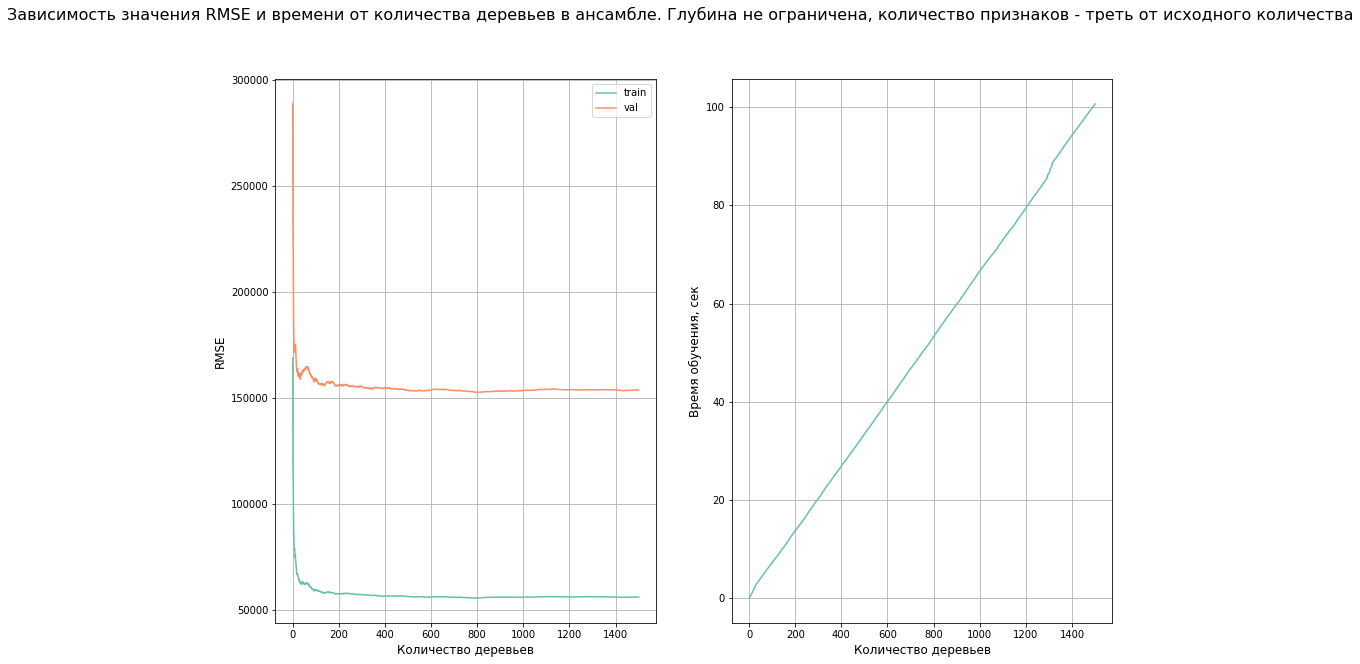

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(15,10))
sns.set_palette("Set2")
fig.suptitle(r'Зависимость значения RMSE и времени от количества деревьев в ансамбле. Глубина не ограничена, количество признаков - треть от исходного количества', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

forest = RandomForestMSE(n_estimators=1500)
forest.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
plt.plot(np.arange(1, 1501), forest.rmse_train, label='train')
plt.plot(np.arange(1, 1501), forest.rmse_val, label='val')
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('Время обучения, сек', fontsize=12)
plt.grid(True)
plt.plot(np.arange(1, 1501), forest.times)

In [ ]:
np.argmin(forest.rmse_val)

812

In [ ]:
forest.rmse_val[812]

152575.09420824546

In [ ]:
min(forest.rmse_train)

55578.115270995964

In [ ]:
fig.savefig('n_estimators.pdf', bbox_inches='tight')

In [59]:
times = []
train_l = []
val_l = []
feat = [1, 3, 5, 7, 10, 13, 15, 17, 21]
for i in range(len(feat)):
  model = RandomForestMSE(n_estimators=812, feature_subsample_size=feat[i])
  model.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
  times.append(model.times[-1])
  train_l.append(model.rmse_train[-1])
  val_l.append(model.rmse_val[-1])

No handles with labels found to put in legend.


([<matplotlib.axis.XTick at 0x7fae287948d0>,
 <a list of 9 Text major ticklabel objects>)

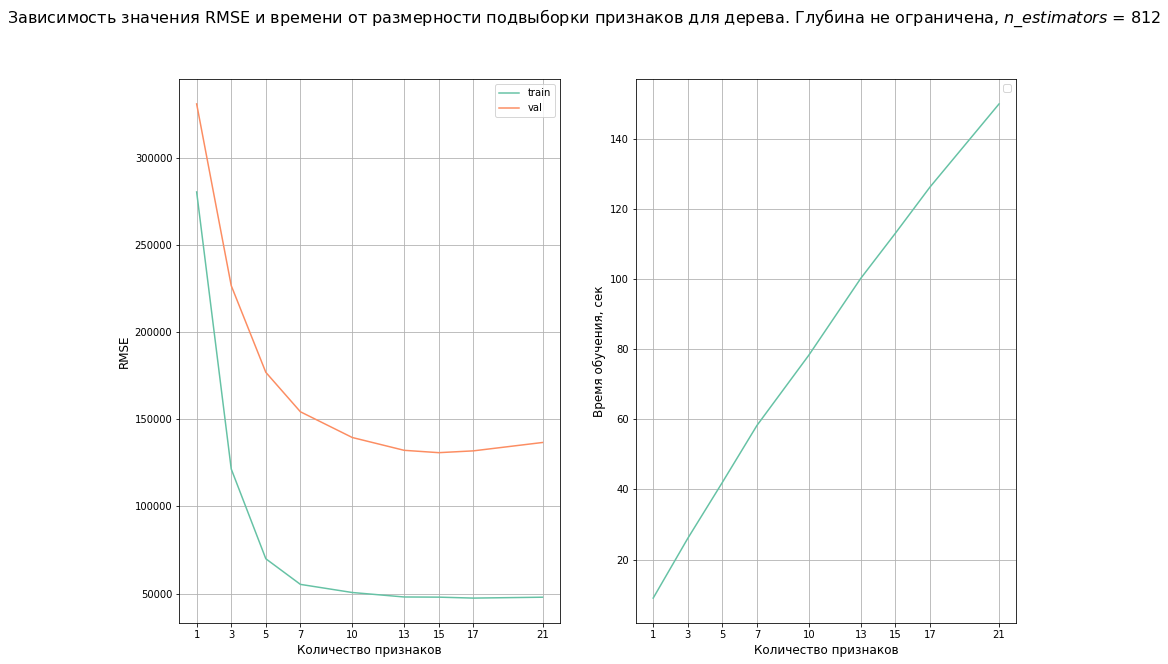

In [60]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("Set2")
fig.suptitle(r'Зависимость значения RMSE и времени от размерности подвыборки признаков для дерева. Глубина не ограничена, $n\_estimators$ = 812', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

plt.plot(feat, train_l, label='train')
plt.plot(feat, val_l, label='val')
plt.xticks(feat)
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('Время обучения, сек', fontsize=12)
plt.grid(True)
plt.plot(feat, times)
plt.legend(fontsize = 10)
plt.xticks(feat)

In [61]:
fig.savefig('fss.pdf', bbox_inches='tight')

In [30]:
times = []
train_l = []
val_l = []
depth = [1, 5, 10, 15, 20, 25, None]
for i in range(len(depth)):
  model = RandomForestMSE(n_estimators=812, feature_subsample_size=15, max_depth=depth[i])
  model.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
  times.append(model.times[-1])
  train_l.append(model.rmse_train[-1])
  val_l.append(model.rmse_val[-1])

([<matplotlib.axis.XTick at 0x7fae2a3c5610>,
 [Text(0, 0, '1'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '15'),
  Text(0, 0, '20'),
  Text(0, 0, '25'),
  Text(0, 0, 'Неогранич. глубина')])

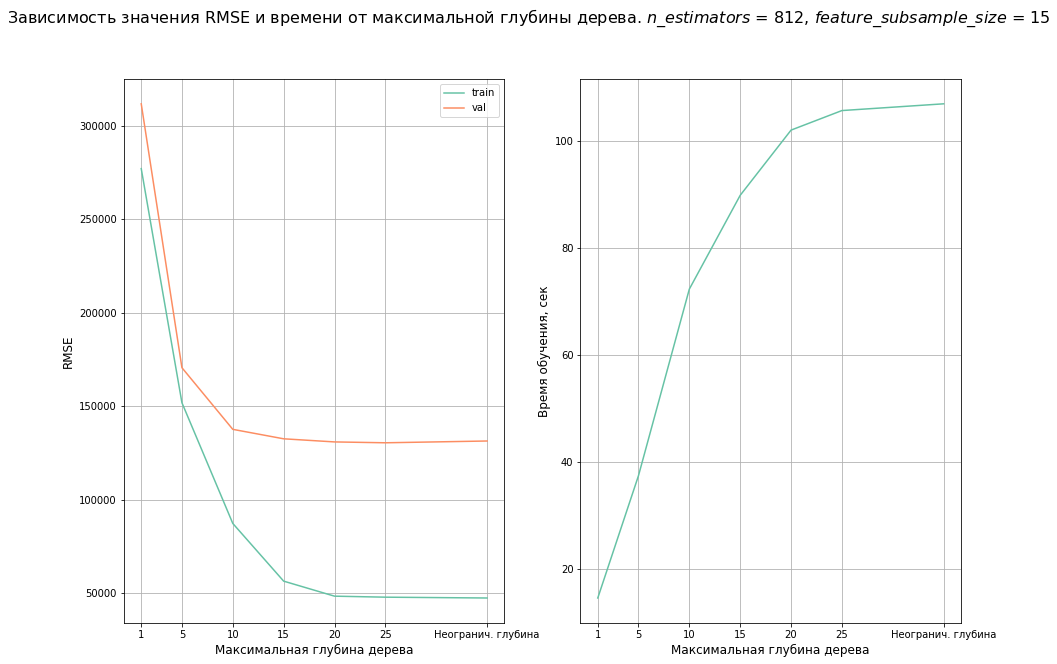

In [33]:
fig = plt.figure(figsize=(15,10))
depth = [1, 5, 10, 15, 20, 25, 30]
sns.set_palette("Set2")
fig.suptitle(r'Зависимость значения RMSE и времени от максимальной глубины дерева. $n\_estimators$ = 812, $feature\_subsample\_size$ = 15', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

plt.plot(depth[:-1] + [35], train_l, label='train')
plt.plot(depth[:-1] + [35], val_l, label='val')
plt.xticks(ticks=depth[:-1] + [35], labels=depth[:-1] + ['Неогранич. глубина'])
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('Время обучения, сек', fontsize=12)
plt.grid(True)
plt.plot(depth[:-1] + [35], times)
plt.xticks(ticks=depth[:-1] + [35], labels=depth[:-1] + ['Неогранич. глубина'])

In [34]:
fig.savefig('depth.pdf', bbox_inches='tight')

Градиентный бустинг

In [45]:
lr = [0.01, 0.05, 0.1, 0.3, 0.5, 1]
model = [0, 0, 0, 0, 0, 0]

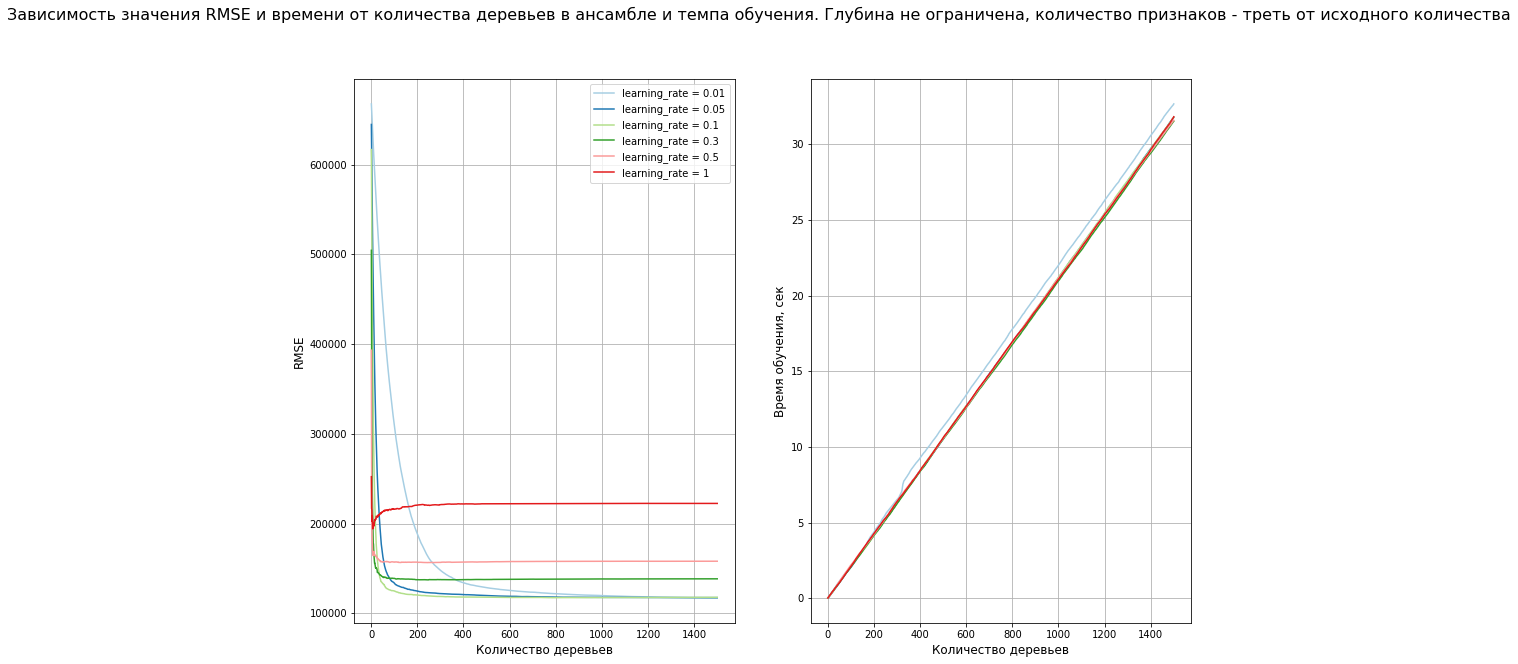

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(15,10))
sns.set_palette("Paired")
fig.suptitle(r'Зависимость значения RMSE и времени от количества деревьев в ансамбле и темпа обучения. Глубина не ограничена, количество признаков - треть от исходного количества', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

for i in range(len(lr)):
  model[i] = GradientBoostingMSE(n_estimators=1500, learning_rate=lr[i])
  model[i].fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
  plt.plot(np.arange(1, 1501), model[i].rmse_val, label='learning_rate = ' + str(lr[i]))
plt.legend(fontsize=10)

ax = fig.add_subplot(122)
for i in range(len(lr)):
  plt.xlabel('Количество деревьев', fontsize=12)
  plt.ylabel('Время обучения, сек', fontsize=12)
  plt.grid(True)
  plt.plot(np.arange(1, 1501), model[i].times)

In [47]:
fig.savefig('gb_n_estim.pdf', bbox_inches='tight')

In [56]:
times = []
train_l = []
val_l = []
feat = [1, 3, 5, 7, 10, 13, 15, 17, 21]
for i in range(len(feat)):
  model = GradientBoostingMSE(n_estimators=400, feature_subsample_size=feat[i], learning_rate=0.1)
  model.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
  times.append(model.times[-1])
  train_l.append(model.rmse_train[-1])
  val_l.append(model.rmse_val[-1])

No handles with labels found to put in legend.


([<matplotlib.axis.XTick at 0x7fae2a235710>,
 <a list of 9 Text major ticklabel objects>)

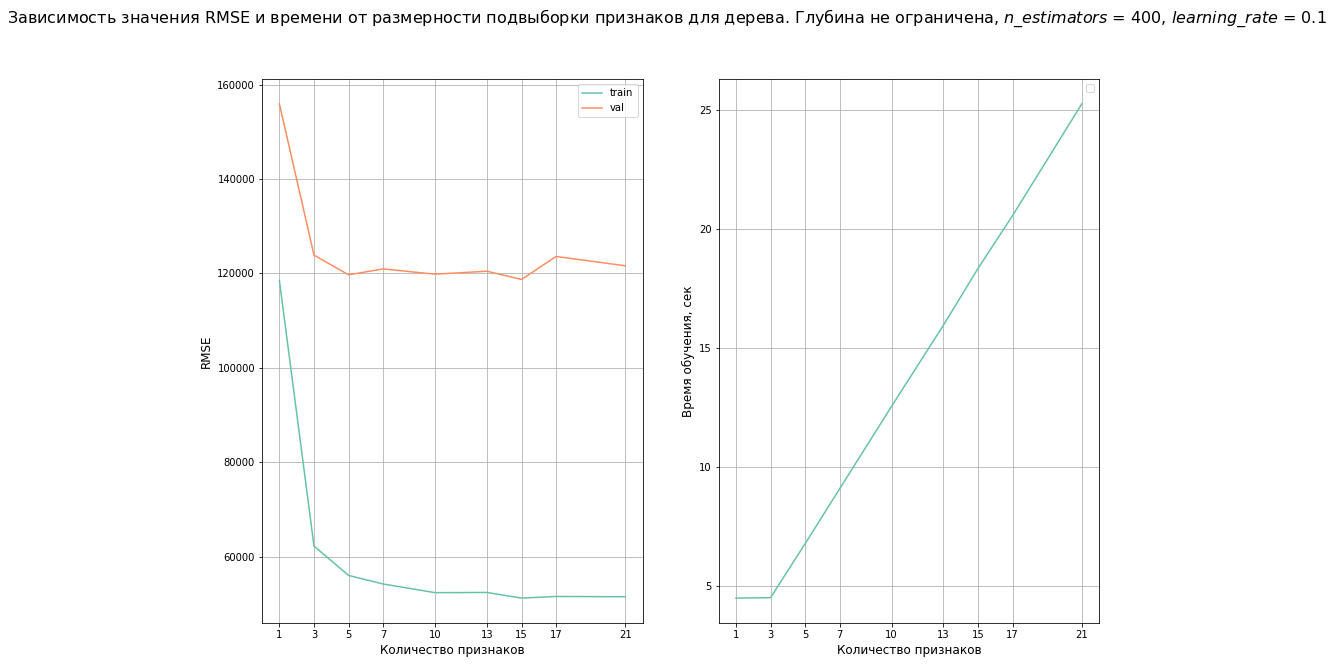

In [57]:
fig = plt.figure(figsize=(15,10))
sns.set_palette("Set2")
fig.suptitle(r'Зависимость значения RMSE и времени от размерности подвыборки признаков для дерева. Глубина не ограничена, $n\_estimators$ = 400, $learning\_rate$ = 0.1', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

plt.plot(feat, train_l, label='train')
plt.plot(feat, val_l, label='val')
plt.xticks(feat)
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('Время обучения, сек', fontsize=12)
plt.grid(True)
plt.plot(feat, times)
plt.legend(fontsize = 10)
plt.xticks(feat)

In [58]:
fig.savefig('gb_fss.pdf', bbox_inches='tight')

In [52]:
times = []
train_l = []
val_l = []
depth = [1, 5, 10, 15, 20, 25, None]
for i in range(len(depth)):
  model = GradientBoostingMSE(n_estimators=400, feature_subsample_size=10, 
                          max_depth=depth[i], learning_rate=0.1)
  model.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
  times.append(model.times[-1])
  train_l.append(model.rmse_train[-1])
  val_l.append(model.rmse_val[-1])

([<matplotlib.axis.XTick at 0x7fae28537b50>,
 [Text(0, 0, '1'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '15'),
  Text(0, 0, '20'),
  Text(0, 0, '25'),
  Text(0, 0, 'Неогранич. глубина')])

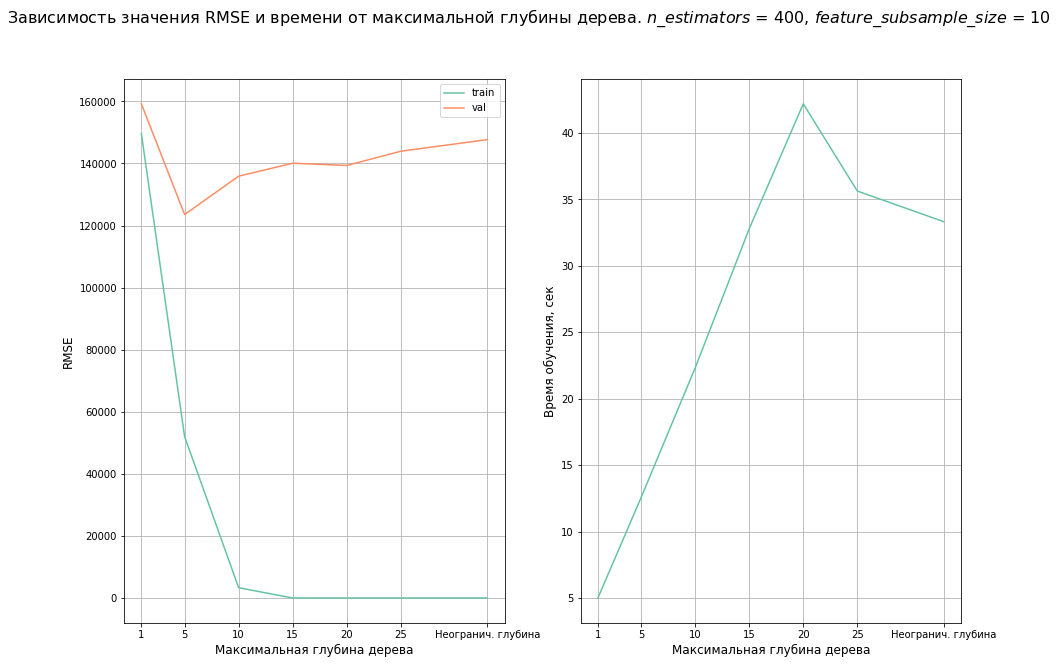

In [54]:
fig = plt.figure(figsize=(15,10))
depth = [1, 5, 10, 15, 20, 25, 30]
sns.set_palette("Set2")
fig.suptitle(r'Зависимость значения RMSE и времени от максимальной глубины дерева. $n\_estimators$ = 400, $feature\_subsample\_size$ = 10', fontsize=16)

ax = fig.add_subplot(121)
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

plt.plot(depth[:-1] + [33], train_l, label='train')
plt.plot(depth[:-1] + [33], val_l, label='val')
plt.xticks(ticks=depth[:-1] + [33], labels=depth[:-1] + ['Неогранич. глубина'])
plt.legend(fontsize = 10)

ax = fig.add_subplot(122)
plt.xlabel('Максимальная глубина дерева', fontsize=12)
plt.ylabel('Время обучения, сек', fontsize=12)
plt.grid(True)
plt.plot(depth[:-1] + [33], times)
plt.xticks(ticks=depth[:-1] + [33], labels=depth[:-1] + ['Неогранич. глубина'])

In [55]:
fig.savefig('gb_depth.pdf', bbox_inches='tight')

Сравнение

In [64]:
model1 = RandomForestMSE(n_estimators=812, feature_subsample_size=15, max_depth=None)
model1.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))
print(f"RMSE RF = {model1.rmse_val[-1]}, time = {model1.times[-1]}")
model = GradientBoostingMSE(n_estimators=400, feature_subsample_size=15, 
                          max_depth=5, learning_rate=0.1)
model.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))
print(f"RMSE GB = {model.rmse_val[-1]}, time = {model.times[-1]}")

RMSE RF = 145063.09647218365, time = 109.13949227333069
RMSE GB = 125832.29498470586, time = 16.949707746505737
